In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
from glob import glob
import h5py
from kneed import KneeLocator
import math
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

In [3]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'

# Compile Effects

In [4]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.4, 0.5)]

In [5]:
sessions = [f[:-4] for f in os.listdir('/om/user/eisenaj/datasets/anesthesia/mat/propofolPuffTone') if f.endswith('.mat')]

In [6]:
average_criticalities = {}
num_indices = {}
for area in ['7b', 'CPB', 'FEF', 'vlPFC', 'all']:
    average_criticalities[area] = {}
    num_indices[area] = {}
    for section in ['pre', 'induction', 'during', 'post']:
        average_criticalities[area][section] = {}
        num_indices[area][section] = {}
        for window in windows:
            average_criticalities[area][section][window] = 0
            num_indices[area][section][window] = 0

In [7]:
for j, session in enumerate(tqdm(sessions)):
    # SESSION INFO
    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, verbose=False)
    session_info = session_vars['sessionInfo']
    
    data_class = get_data_class(session, all_data_dir)
    results_dir = f'/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR'

    eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
    slice_funcs = dict(
        pre=lambda window: slice(0, int(session_info['drugStart'][0]/window)),
        induction=lambda window: slice(int(session_info['drugStart'][0]/window), int(eyes_close/window)),
        during=lambda window: slice(int(eyes_close/window), int(session_info['drugEnd'][1]/window)),
        post=lambda window: slice(int(session_info['drugEnd'][1]/window),-1)
    )
    
    
    for i, window in enumerate(windows):
        
        session_window_dir = get_result_path(results_dir, session, window)
        VAR_results = {}
        for area in os.listdir(session_window_dir):
            VAR_results[area] = load(os.path.join(session_window_dir, area))
        
        for area in ['7b', 'CPB', 'FEF', 'vlPFC', 'all']:
            for section in ['pre', 'induction', 'during', 'post']:
                average_criticalities[area][section][window] += VAR_results[area][slice_funcs[section](window)].criticality_inds.sum().sum()
                num_indices[area][section][window] += len(VAR_results[area][slice_funcs[section](window)])*VAR_results[area][slice_funcs[section](window)].criticality_inds.iloc[0].shape[0]

  0%|          | 0/21 [00:00<?, ?it/s]

In [9]:
save({'average_criticalities': average_criticalities, 'num_indices': num_indices}, "/om/user/eisenaj/ChaoticConsciousness/increase_window")

In [13]:
for area in average_criticalities.keys():
    for section in average_criticalities[area].keys():
        for window in average_criticalities[area][section].keys():
            average_criticalities[area][section][window] /= num_indices[area][section][window]

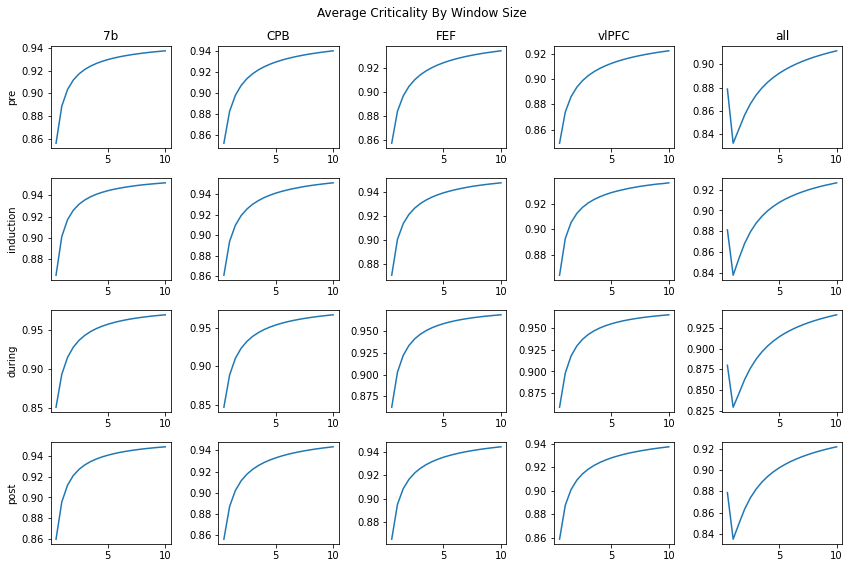

In [18]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

for i, section in enumerate(['pre', 'induction', 'during', 'post']):
    for j, area in enumerate(['7b', 'CPB', 'FEF', 'vlPFC', 'all']):
        ax = axs[int((i*5 + j)/5)][(i*5 + j)%5]
        ax.plot(windows, [average_criticalities[area][section][window] for window in windows])

for i, ax in enumerate(axs[:, 0]):
    ax.set_ylabel(['pre', 'induction', 'during', 'post'][i])
    
for i, ax in enumerate(axs[0]):
    ax.set_title(['7b', 'CPB', 'FEF', 'vlPFC', 'all'][i])

plt.suptitle('Average Criticality By Window Size')
plt.tight_layout()
plt.show()